In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/depression/depression_test.csv
/kaggle/input/depression/depression_train.csv


In [2]:
# importing required libraries 

import pandas as pd
import numpy as np
# for pytorch imports
import torch

# for functional dependencies like activation function 
import torch.nn.functional as F

# nn is basic module in Torch which provide different neural network architecture
import torch.nn as nn

# for optimizer
import torch.optim as optim

# CountVectorizer for Bagof words model
from sklearn.feature_extraction.text import CountVectorizer

# for padding .. since the LSTM takes input as sequence so it is said that 
#if we have fixed input string computation will be faster and it will improve performance 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook

# MODEL1

In [3]:
class Sequences(Dataset):
    def __init__(self, path, max_seq_len):
        self.max_seq_len = max_seq_len
        df = path
        
        # BOW 
        vectorizer = CountVectorizer(stop_words='english', min_df=0.015)
        vectorizer.fit(df.Text_data.tolist())
        
        # Creating Vocabulary
        self.token2idx = vectorizer.vocabulary_
        
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.Text_data.tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df.Label.tolist()) if sequence])
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [4]:
test_data  = pd.read_csv('../input/depression/depression_test.csv')
train_data  = pd.read_csv('../input/depression/depression_train.csv')
test_data.head()

Text_data     Label
0  I enjoyed today, and I still am! Tomorrows dep...  moderate
1  I sorta tried to kill myself : I had a total b...  moderate
2  Best suicide method? : I like it quick and eas...  moderate
3  a story : I remember the time I'd get on my 3D...  moderate
4  The world only cares about beautiful people : ...  moderate

In [5]:
train_data.head()

Text_data     Label
0  Waiting for my mind to have a breakdown once t...  moderate
1  My new years resolution : I'm gonna get my ass...  moderate
2  New year : Somone else Feeling like 2020 will ...  moderate
3  My story I guess : Hi, Im from Germany and my ...  moderate
4  Sat in the dark and cried myself going into th...  moderate

In [6]:
labeling = {'moderate':1, 'severe':2, 'not depression':0}
test_data['Label'] = test_data['Label'].apply(lambda x : labeling[x])
test_data.shape

(4496, 2)

In [7]:
labeling = {'moderate':1, 'severe':2, 'not depression':0}
train_data['Label'] = train_data['Label'].apply(lambda x : labeling[x])
train_data.shape

(8891, 2)

In [8]:
# feeding data in class and getting its instance in return 
dataset = Sequences(train_data, max_seq_len=128)
len(dataset.token2idx)

578

In [9]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs, target

batch_size = 2048
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)

In [10]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        batch_size,
        embedding_dimension=100,
        hidden_size=128, 
        n_layers=1,
        device='cpu'
    ):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        self.rnn = nn.LSTM(
            embedding_dimension,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.decoder = nn.Linear(hidden_size, 1)
        
    def init_hidden(self ):
        
        return (torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device),
                torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device) )
       
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded, self.init_hidden())
        #o
        output = self.decoder(output[:, :, -1]).squeeze()
        return output

In [11]:
model = RNN(
    hidden_size=128,
    vocab_size=len(dataset.token2idx),
    batch_size=batch_size
)
model

RNN(
  (encoder): Embedding(578, 100)
  (rnn): LSTM(100, 128, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [13]:
model.train()
train_losses = []
for epoch in range(5):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        inputs, target = inputs, target
        model.zero_grad()
        
        output = model(inputs)
    
        loss = criterion(output, target)
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)

    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.695


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.616


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.495


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.370


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.261


# MODEL2

# Generating word frequencies

In [14]:
def gen_freq(text):
    #will store all the words in list
    words_list = []
    
    #Loop over all the words and extract word from list
    for word in text.split():
        words_list.extend(word)
        
    #Generate word frequencies using value counts in word_list
    word_freq = pd.Series(words_list).value_counts()
    
    #print top 100 words
    word_freq[:100]
    
    return word_freq  

In [15]:
freq = gen_freq(train_data.Text_data.str)
freq

I             64393
to            41555
and           37184
the           25629
a             24058
              ...  
Avery             1
wolf.             1
kink              1
mid-Oct,          1
(somewhat)        1
Length: 26915, dtype: int64

# Word cloud

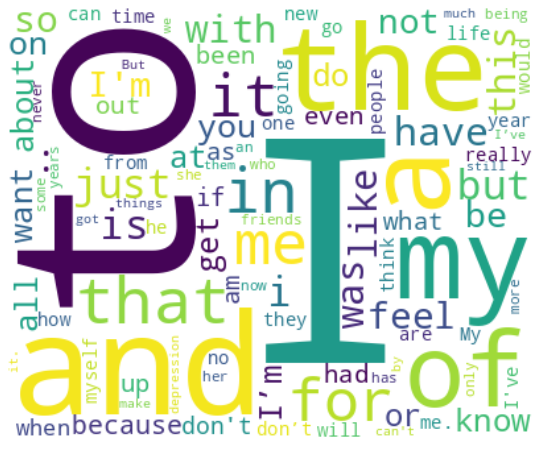

In [16]:
#Import library WordCloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(freq)

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Moderate depression word cloud

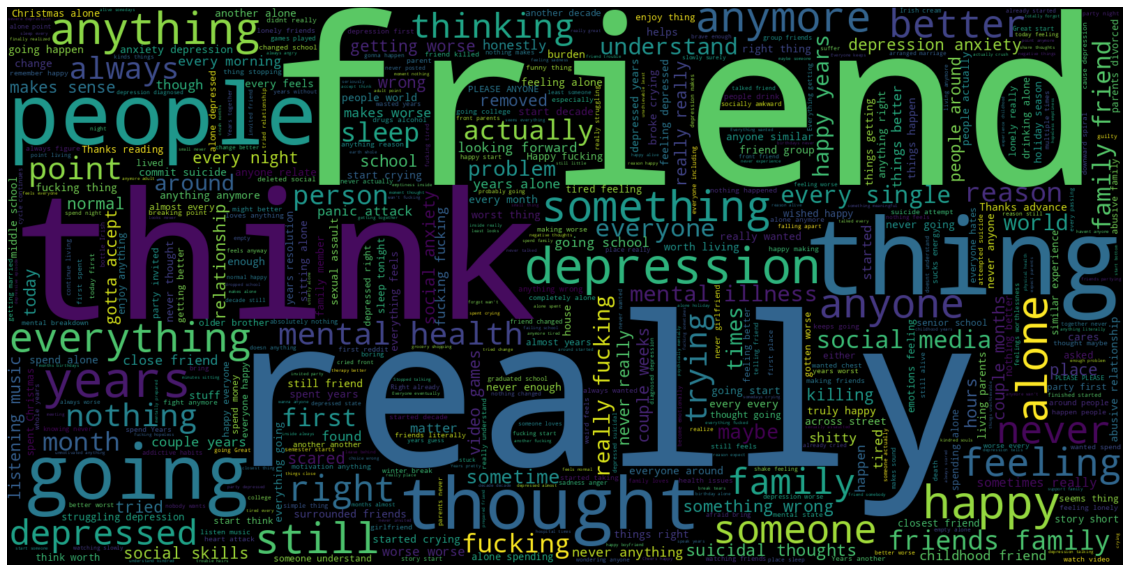

In [17]:
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(train_data[train_data.Label == 1].Text_data))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

# Not depression word cloud

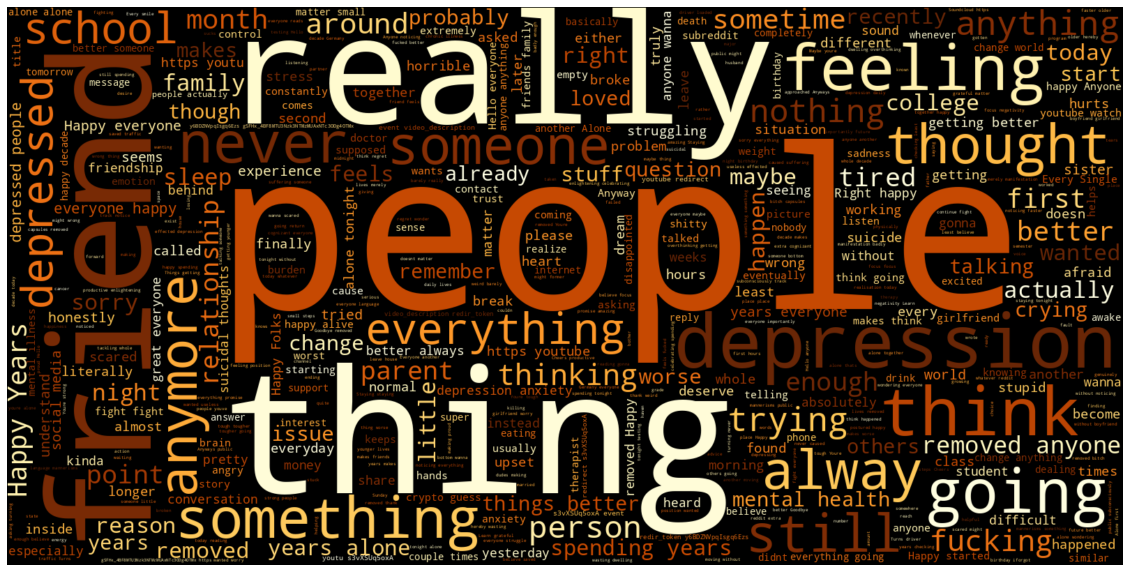

In [18]:
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,colormap="YlOrBr",
               min_word_length=5).generate(" ".join(train_data[train_data.Label == 0].Text_data))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

# Severe depression word cloud

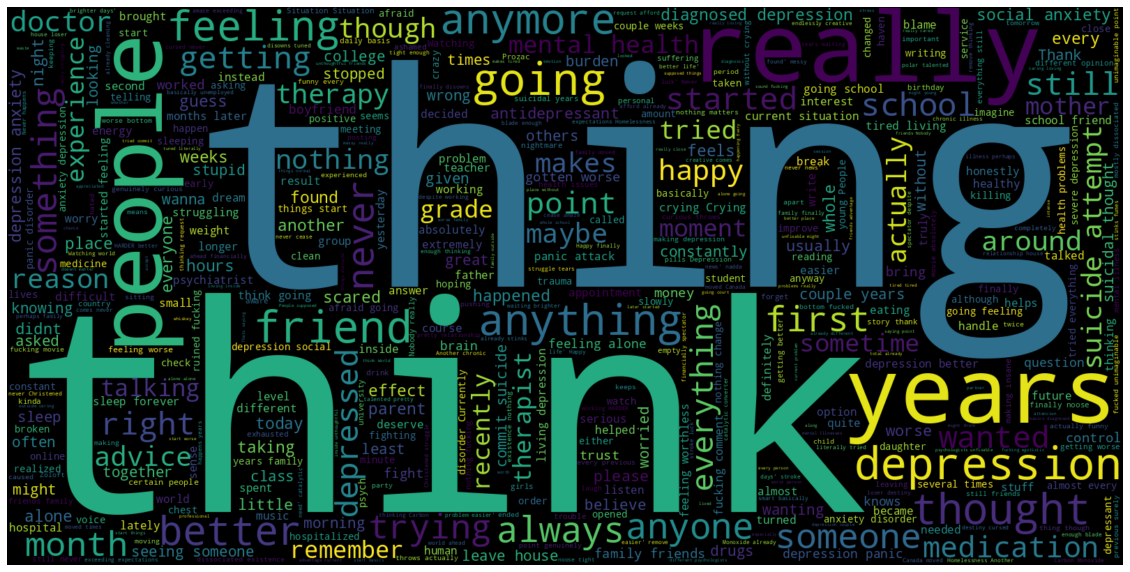

In [19]:
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(train_data[train_data.Label == 2].Text_data))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

# Removing stop words

In [20]:
from nltk.corpus import stopwords
stop_word_list = stopwords.words('english')

In [21]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#Tokenization of text
tokenizer=ToktokTokenizer()

In [22]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_word_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
train_data['Text_data']= train_data['Text_data'].apply(remove_stopwords)

In [23]:
import re
#clearing punctuation & unnecessary marks
train_data['Text_data'] = train_data['Text_data'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
train_data['Text_data'] = train_data['Text_data'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#capitalization to lowercase
train_data['Text_data'] = train_data['Text_data'].apply(lambda x: x.lower())

#cleaning extra spaces
train_data['Text_data'] = train_data['Text_data'].apply(lambda x: x.strip())

In [24]:
from bs4 import BeautifulSoup
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    return text

#Apply function on review column
    text = strip_html(text)
    text = remove_between_square_brackets(text)
train_data['Text_data']=train_data['Text_data'].apply(denoise_text)
data_copy = train_data.copy()

# Word clouds after text cleaning

In [25]:
train_data.head()

Text_data  Label
0  waiting mind breakdown  new year   feeling   a...      1
1  new years resolution    gonna get ass therapis...      1
2  new year  somone else feeling like      last y...      1
3  story guess  hi  im germany english mostly sel...      1
4          sat dark cried going new year great start      1

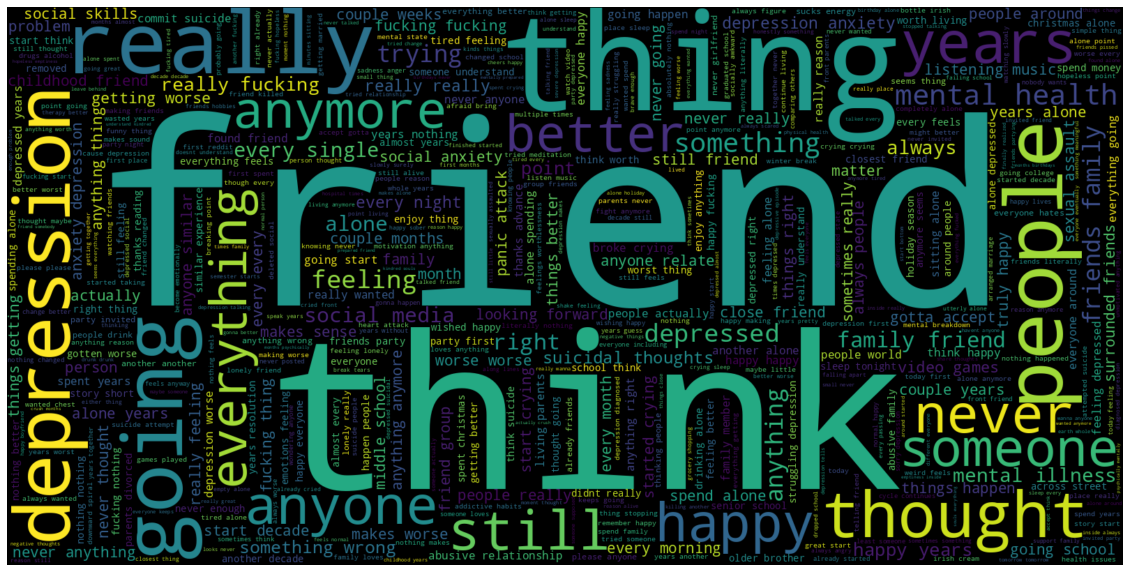

In [26]:
# Moderate depression
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(train_data[train_data.Label == 1].Text_data))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

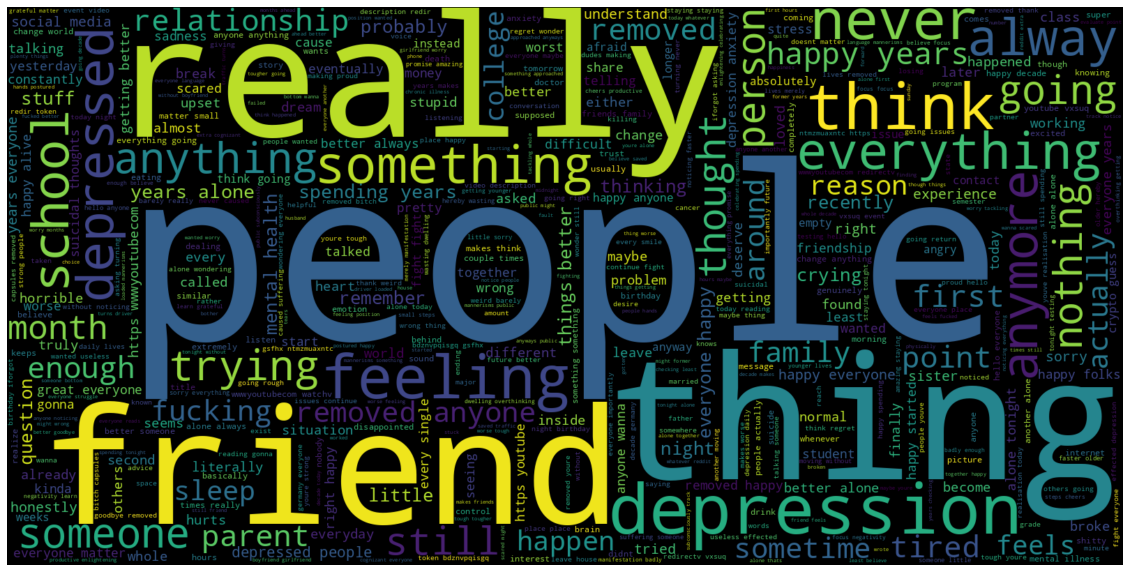

In [27]:
# Not depressed
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(train_data[train_data.Label == 0].Text_data))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

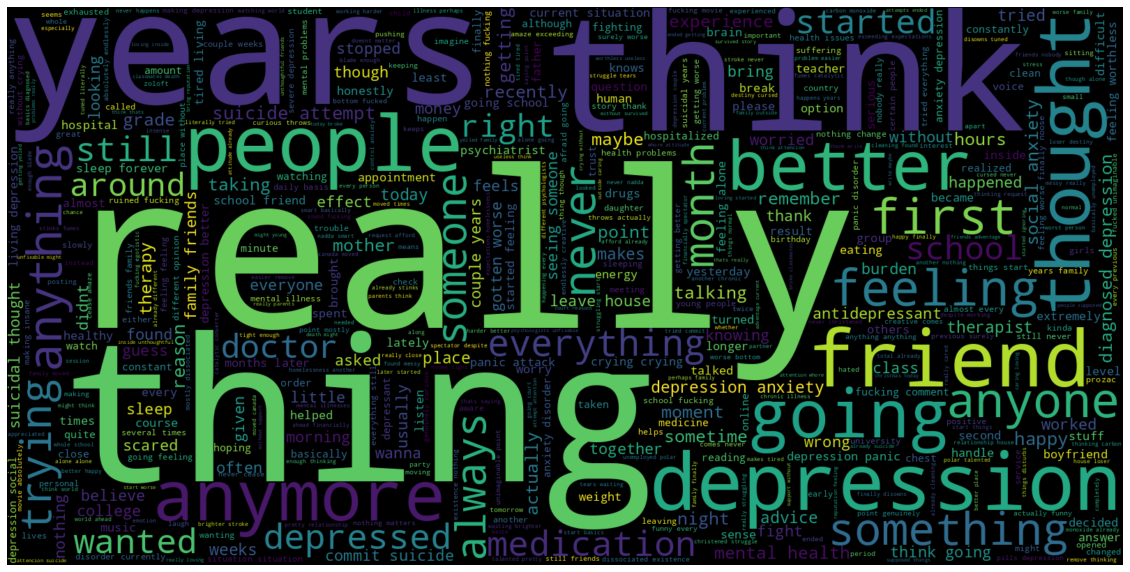

In [28]:
# Severe depression
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(train_data[train_data.Label == 2].Text_data))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

# Test-train split

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data[:4496],test_data,test_size = 0.2, random_state = 42)

# Dictionary

In [30]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(train_data)
#tokenizer.word_index

In [31]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [32]:
#Then we take the word count of each of our sentences in our data and create a list.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
#Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

2

In [33]:
#percentage of the data this determined number covers.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.5

In [34]:
import keras
#data is adjusted according to the number of tokens specified
x_train_pad = keras.preprocessing.sequence.pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test_tokens, maxlen=max_tokens)
x_train_pad.shape

(2, 2)

In [35]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [36]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.layers import GRU
from tensorflow.keras.optimizers import Adam
model = Sequential()

embedding_size = 50

model.add(Embedding(input_dim=15000,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))

model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=8, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=4))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

2022-04-10 10:34:46.337448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 10:34:46.338574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 10:34:46.339269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 10:34:46.340083: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 2, 50)             750000    
_________________________________________________________________
lstm (LSTM)                  (None, 2, 16)             4288      
_________________________________________________________________
dropout (Dropout)            (None, 2, 16)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 8)              800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 8)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0

In [38]:
#X_train, X_remain, y_train, y_remain = train_test_split(df.to_numpy(), test_size=0.2, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(x_train_pad, x_test_pad, test_size=0.5, random_state=1)
print(X_valid)
print(X_test)
print(y_valid)
print(y_test)

[[0 3]]
[[1 2]]
[[0 3]]
[[1 2]]


In [39]:
from nltk.corpus import stopwords
english_stops = set(stopwords.words('english')) #declaring stop words

def load_dataset():
    df = pd.read_csv('../input/depression/depression_train.csv')
    x_data = df['Text_data']       # Reviews/Input
    y_data = df['Label']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('moderate', 1)
    y_data = y_data.replace('not depressed', 0)
    y_data = y_data.replace('severe', 2)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Text_data')
print(x_data, '\n')
print('Label')
print(y_data)

Text_data
0       [waiting, mind, breakdown, new, year, feeling,...
1       [my, new, years, resolution, i, gonna, get, as...
2       [new, year, somone, else, feeling, like, last,...
3       [my, story, i, guess, hi, im, germany, english...
4       [sat, dark, cried, going, new, year, great, st...
                              ...                        
8886    [ways, reverse, memory, loss, depression, i, s...
8887    [a, comprehensive, guide, to, slowly, getting,...
8888    [i, think, college, right, tw, suicide, mentio...
8889    [please, help, severe, insomnia, affecting, ma...
8890    [with, passing, day, depression, getting, wors...
Name: Text_data, Length: 8891, dtype: object 

Label
0       1
1       1
2       1
3       1
4       1
       ..
8886    2
8887    2
8888    2
8889    2
8890    2
Name: Label, Length: 8891, dtype: object


In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
6465    [happy, new, years, happy, new, years, people,...
4763    [i, always, put, situations, go, anywhere, it,...
1483    [feeling, like, shit, every, post, i, see, dri...
2411    [this, i, thought, new, decade, would, come, i...
8799    [tw, self, harm, mention, hey, so, i, posting,...
                              ...                        
8270    [i, empty, i, wake, malevolent, glare, life, i...
2218    [i, fucking, hate, new, years, everyone, tries...
1323    [how, get, courage, speak, just, gone, years, ...
1947    [my, dog, helped, last, months, poisoned, i, a...
8543    [this, world, making, go, insane, its, first, ...
Name: Text_data, Length: 6223, dtype: object 

1338    [alone, all, alone, new, year, my, friends, ba...
5159    [alone, new, years, this, one, goes, brothers,...
4821    [feeling, alone, nye, party, i, went, first, r...
1282               [anyone, else, hate, mirrors, removed]
8438    [i, feel, like, shit, i, feel, like, shit, i, ...
               

In [41]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[  27   11   16 ...    0    0    0]
 [   1   43  190 ...    0    0    0]
 [  37    2   62 ...    0    0    0]
 ...
 [ 201    8 1172 ...   86  108 2307]
 [  19  487  439 ...    0    0    0]
 [  80  160  168 ...  157  356  197]] 

Encoded X Test
 [[  28  241   28 ...    0    0    0]
 [  28   11   16 ...    0    0    0]
 [  37   28  273 ...  400  460   40]
 ...
 [   1  128 7754 ...    0    0    0]
 [   1  194   21 ...    3    1   21]
 [ 939  825 6164 ...    0    0    0]] 

Maximum review length:  79


In [43]:
from tensorflow.keras.models import Sequential     
from tensorflow.keras.layers import Embedding, LSTM, Dense 
from tensorflow.keras.callbacks import ModelCheckpoint   
from tensorflow.keras.models import load_model
# LSTM Model
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 79, 32)            345248    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 370,145
Trainable params: 370,145
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import collections
import itertools

In [45]:
df=pd.read_csv('../input/depression/depression_train.csv')
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    return ' '.join(x.lower() for x in texts.split())
df['Text_data_cleaned'] = df['Text_data'].apply(lambda x : preprocessing_text(x))
df

Text_data     Label  \
0     Waiting for my mind to have a breakdown once t...  moderate   
1     My new years resolution : I'm gonna get my ass...  moderate   
2     New year : Somone else Feeling like 2020 will ...  moderate   
3     My story I guess : Hi, Im from Germany and my ...  moderate   
4     Sat in the dark and cried myself going into th...  moderate   
...                                                 ...       ...   
8886  Ways to reverse memory loss from depression? :...    severe   
8887  A Comprehensive Guide To Slowly Getting Better...    severe   
8888  I don’t think college is right for me : TW: su...    severe   
8889  Please help: Severe insomnia affecting me in m...    severe   
8890  With each passing day my depression is getting...    severe   

                                      Text_data_cleaned  
0     waiting for my mind to have a breakdown once t...  
1     my new years resolution i m gonna get my ass i...  
2     new year somone else feeling like will be ther...  
3     my story i guess hi im from germany and my eng...  
4     sat in the dark and cried myself going into th...  
...                                                 ...  
8886  ways to reverse memory loss from depression i ...  
8887  a comprehensive guide to slowly getting better...  
8888  i don t think college is right for me tw suici...  
8889  please help severe insomnia affecting me in ma...  
8890  with each passing day my depression is getting...  

[8891 rows x 3 columns]

# LSTM for 500 characters

In [46]:
df['Text_data_cleaned_500'] = df['Text_data_cleaned'].apply(lambda x:x[:500])

df['Text_data_cleaned_500'][2]

'new year somone else feeling like will be there last year on earth because even wen your hammerd your feeling like a moron thats depressed'

# Tokenize and padding

In [47]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['Text_data_cleaned_500'])
seq = tokenizer.texts_to_sequences(df['Text_data_cleaned_500'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (8891, 143), X_min: 0, X_max: 8314


In [48]:
y = df['Label'].map({'not depressed' : 0, 'moderate' : 1, 'severe':2}).values

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(5689, 143) (1423, 143) (1779, 143) (5689,) (1423,) (1779,)


In [49]:
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [50]:
optimizer =keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

2022-04-10 10:35:04.341117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-10 10:35:08.242199: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


178/178 [==============================] - 12s 35ms/step - loss: nan - accuracy: 0.0026 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
178/178 [==============================] - 4s 24ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
178/178 [==============================] - 5s 27ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/5
178/178 [==============================] - 4s 24ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/5
178/178 [==============================] - 4s 24ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


<AxesSubplot:>

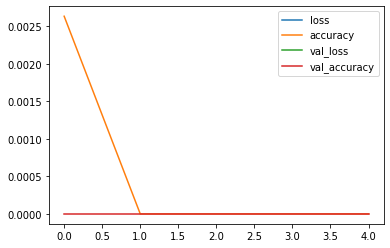

In [51]:
pd.DataFrame(history.history).plot()

# Dropout layers to prevent overfitting

In [52]:
embed_size = 64
model_v2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 64)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [53]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_v2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/20
89/89 [==============================] - 73s 788ms/step - loss: nan - accuracy: 0.0026 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/20
89/89 [==============================] - 72s 805ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/20
89/89 [==============================] - 70s 792ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/20
89/89 [==============================] - 71s 795ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/20
89/89 [==============================] - 70s 787ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


<AxesSubplot:>

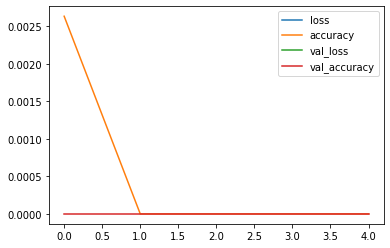

In [54]:
pd.DataFrame(history.history).plot()

In [55]:
data=pd.read_csv('../input/depression/depression_train.csv')

In [56]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

In [57]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }
#function to clean data
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text
data_copy = data.copy()
data['Text_data']=data['Text_data'].apply(clean_text,lemmatize = True)
#converting target variable to numeric labels
def condition(x):
    if x=='moderate':
        return 1
    elif x=='severe':
        return 2
    else:
        return 0
df['Label'] = df['Label'].apply(condition)
df.head()

Text_data  Label  \
0  Waiting for my mind to have a breakdown once t...      1   
1  My new years resolution : I'm gonna get my ass...      1   
2  New year : Somone else Feeling like 2020 will ...      1   
3  My story I guess : Hi, Im from Germany and my ...      1   
4  Sat in the dark and cried myself going into th...      1   

                                   Text_data_cleaned  \
0  waiting for my mind to have a breakdown once t...   
1  my new years resolution i m gonna get my ass i...   
2  new year somone else feeling like will be ther...   
3  my story i guess hi im from germany and my eng...   
4  sat in the dark and cried myself going into th...   

                               Text_data_cleaned_500  
0  waiting for my mind to have a breakdown once t...  
1  my new years resolution i m gonna get my ass i...  
2  new year somone else feeling like will be ther...  
3  my story i guess hi im from germany and my eng...  
4  sat in the dark and cried myself going into th...

In [58]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.Text_data)
corpus[:5]

['waiting', 'mind', 'breakdown', 'feeling', 'anymore']

In [59]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

corpus  countv
0    like    9236
1    feel    8674
2    year    8313
3    know    6011
4    want    5684
5    life    5592
6     get    5344
7    time    5271
8    even    4393
9  friend    4227

In [60]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

In [61]:
#splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['Text_data'], train['Label']
Xtest, ytest = test['Text_data'], test['Label']
#Vectorizing data

tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

# LSTM

In [62]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  10871


In [63]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1385


In [64]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 239


In [65]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 95.87 % of data


In [66]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train[:4551],ytrain,
                                             test_size=0.2,random_state=10)
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    

    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

ValueError: Found input variables with inconsistent numbers of samples: [4551, 7112]

In [ ]:
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
stop_words = set(stopwords.words('english'))
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
#Data Processing — convert to lower case, Remove punctuation etc
def data_preprocessing(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text) # Remove HTML from text
    text = ''.join([c for c in text if c not in string.punctuation])# Remove punctuation
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

df['cleaned_reviews'] = df['review'].apply(data_preprocessing)
df.head()

In [ ]:
#Tokenize
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

In [ ]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for text in df['cleaned_reviews']:
    r = [vocab_to_int[word] for word in text.split()]
    reviews_int.append(r)

print(reviews_int[:1])
df['Review int'] = reviews_int

In [ ]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df.head()

In [ ]:
review_len = [len(x) for x in reviews_int]
df['Review len'] = review_len
df.head()

# Padding/truncating

In [ ]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
            
    return features
features = Padding(reviews_int, 200)
print(features[0, :])

In [ ]:
X_train, X_remain, y_train, y_remain = train_test_split(features, df['sentiment'].to_numpy(), test_size=0.2, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
# create tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

In [ ]:
class sentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()
        
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        
        #embedding and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        #stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        #sigmoid function
        sig_out = self.sigmoid(out)
        
        # reshape to be batch size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim))
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim))
        hidden = (h0,c0)
        return hidden

In [ ]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

clip = 5
epochs = 2
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels 
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
            
        accuracy = acc(output,labels)
        val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
test_h = model.init_hidden(batch_size)

model.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)
    
    output, test_h = model(inputs, test_h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.layers import GRU
embedding_vecor_length = 50
max_review_length = 1000
NUM_WORDS = 10000

model = Sequential()
model.add(Embedding(NUM_WORDS, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(GRU(50, return_sequences=True))
model.add(GRU(50))
model.add(Dropout(0.5))
model.add(Dense(100,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics='accuracy')
model.summary()

In [ ]:
model.fit(X_train,y_train,epochs=5,batch_size=100,validation_data = (X_test,y_test),shuffle=True)

In [ ]:
print("Accuracy: ", np.round(model.evaluate(xte3,yte,verbose=0)[1]*100,3),"%")